In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler


#Custome graph format style sheet
plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    location = 'E:\\Documents\\Dan\\Code\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'



In [2]:
# Task Specific includes:

#import scipy.special as sp
import math
import matplotlib.animation as animation
import time
from numpy import inf
# Choose which EFIT_Class to use:
# import EFIT_Class as EFIT
# import EFIT_Class_StressLargerVelocity as EFIT
import EFIT_Class_OrignalEqualGrid as EFIT
# import EFIT_Class_Parallel_EqualGrid as EFIT
# import EFIT_Class_VelocityLargerStress as EFIT
import visvis as vv

In [3]:
# set Constants:
PoissonRatio = 0.3
YoungModulus = 20 * (10**9)
mu = 80 * (10**9)         #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 7800       #density

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

# about 1foot (0.3m) of just the web of 175lbs rail 
# BeamLength = 0.3
# BeamHeight = 0.0762
# BeamWidth = 0.0381
BeamLength = 0.02
BeamHeight = 0.005
BeamWidth = 0.02

5991.446895152781 3202.563076101743


In [4]:
#Run for 6 Cycles:
runtime = 1.0 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
ts = 1 / frequency / 100    #time step
gs = min(omegal, omegat) / 200    #grid step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time STeps

gl = int(math.ceil(BeamLength / gs))         #number of grid points
gh = int(math.ceil(BeamHeight / gs)) 
gw = int(math.ceil(BeamWidth / gs)) 


In [5]:
#Initialize EFIT Model
Rail = EFIT.EFIT(gl, gw, gh, ts, gs)

#Set Material Properties consitant througout
Rail.Gp[0,:,:,:] = rho  #constant Density
Rail.Gp[1,:,:,:] = lmbda #Constant first Lamee parameter 
Rail.Gp[2,:,:,:] = mu  #constant second Lamee parameter


In [6]:
#Run main function for time:
CenterXResults = []
CenterYResults = []
CenterZResults = []
AllVelocities=[]
VelocitiesX=[]
VelocitiesY=[]
VelocitiesZ=[]


t=0
TempZ=Rail.VelocityCut(1,2)
CenterZResults.append((TempZ,t))

# Inputs for forcing Function
Power = 10          #not sure on unit yet, just something for now
EmitterSize = 0.01  # meters, so 1 CM
Dimmension = 2      # 2 is in the z axis 
Direction = 1       # 1 is on top going down
CornerCut = 6       # how much of the corner is taken off of the square emitter
StartStep = 2
EndStep = 4


for i in range(Tsteps - 1):
    t = (i+1) * ts
   
    #update Velocity:
    Rail.StepVelocities()
    
    if i >= StartStep and i <= EndStep: 
        Rail.ForcingFunctionImpulse(Power,EmitterSize,Dimmension,Direction, CornerCut)
    #    Rail.ForcingFunctionWave(t, frequency/2, 1,0.01,2,1)
    #else:
    #    Rail.ForcingFunctionWave(t, frequency, 0)
    
    #Update Stresses at next half step:
    Rail.StepStresses()

    #print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ "{:.3e}".format(t)) #str(t))
    TempZ=Rail.VelocityCut(1,2)
    CenterZResults.append((np.matrix(TempZ),t))
    
    TempGrid = Rail.VelocitySave()
    AllVelocities.append(TempGrid)
    
    TempGrid = Rail.VelocitySave(0)
    VelocitiesX.append(TempGrid)
    
    TempGrid = Rail.VelocitySave(1)
    VelocitiesY.append(TempGrid)
    
    TempGrid = Rail.VelocitySave(2)
    VelocitiesZ.append(TempGrid)
    
    # Store results mid process for latter animating
    if i < 10 or i % 10 == 9:
        print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ "{:.3e}".format(t)) #str(t))
    

        #np.savetxt(str(i)+'V0.csv', Rail.VelocityCut(0), delimiter=",")
        #np.savetxt(str(i)+'V1.csv', Rail.VelocityCut(1), delimiter=",")
        #np.savetxt(str(i)+'V2.csv', Rail.VelocityCut(1), delimiter=",")
        #np.savetxt(str(i)+'S0.csv', Rail.StressCut(0,1,1), delimiter=",")
        #np.savetxt(str(i)+'S1.csv', Rail.StressCut(1,1,1), delimiter=",")
        #np.savetxt(str(i)+'S2.csv', Rail.StressCut(2,1,1), delimiter=",")

    #TempZ=Rail.StressCut(2,1,1)
    #np.savetxt(str(i)+'S11.csv', TempZ, delimiter=",")
    #TempZ=Rail.StressCut(2,1,0)
        #np.savetxt(str(i)+'S10.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,1,2)
        #np.savetxt(str(i)+'S12.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,0,0)
        #np.savetxt(str(i)+'S00.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,0,2)
        #np.savetxt(str(i)+'S02.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,2,2)
        #np.savetxt(str(i)+'S22.csv', TempZ, delimiter=",")


1 of 101 time steps. time is: 2.500e-07
2 of 101 time steps. time is: 5.000e-07
3 of 101 time steps. time is: 7.500e-07
4 of 101 time steps. time is: 1.000e-06
5 of 101 time steps. time is: 1.250e-06
6 of 101 time steps. time is: 1.500e-06
7 of 101 time steps. time is: 1.750e-06
8 of 101 time steps. time is: 2.000e-06
9 of 101 time steps. time is: 2.250e-06
10 of 101 time steps. time is: 2.500e-06
20 of 101 time steps. time is: 5.000e-06
30 of 101 time steps. time is: 7.500e-06
40 of 101 time steps. time is: 1.000e-05
50 of 101 time steps. time is: 1.250e-05
60 of 101 time steps. time is: 1.500e-05
70 of 101 time steps. time is: 1.750e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:672: RuntimeWarning: overflow encountered in square
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:672: RuntimeWarning: overflow encountered in add
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:674: RuntimeWarning: overflow encountered in square
  Results = np.sqrt(Component0**2)
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:676: RuntimeWarning: overflow encountered in square
  Results = np.sqrt(Component1**2)
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:678: RuntimeWarning: overflow encountered in square
  Results = np.sqrt(Component2**2)


80 of 101 time steps. time is: 2.000e-05
90 of 101 time steps. time is: 2.250e-05
100 of 101 time steps. time is: 2.500e-05


C:\Users\Dan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
MovieWriter ffmpeg unavailable; using Pillow instead.


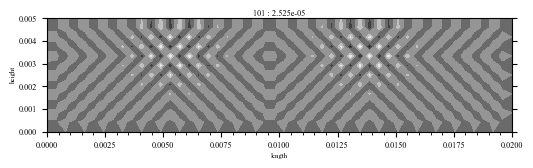

In [7]:
y = np.linspace(0, BeamHeight, np.shape(CenterZResults[0][0])[1])
x = np.linspace(0, BeamLength, np.shape(CenterZResults[0][0])[0])
x,y = np.meshgrid(x,y)

fig = plt.figure(figsize=(6.0,BeamHeight/BeamLength*6.0), dpi=100)
ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamHeight))  
plt.ylabel(r'height')
plt.xlabel(r'length')

# animation function
def animate(i): 
    z = np.matrix(CenterZResults[i][0][:,:]).T
    plt.title(str(i) + ' : ' + "{:.3e}".format(CenterZResults[i][1]))
    cont = plt.contourf(x, y, z, levels=5, cmap='gray') #,vmin=-100, vmax=100)
    #time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterZResults)[0])

anim.save('animationZ.gif')

In [8]:
#x,y,z, Rail.MaxX, Rail.MaxY, Rail.MaxZ
#np.sqrt(Rail.Gv[2,1,:,:]**2+Rail.Gv[0,1,:,:]**2+Rail.Gv[1,1,:,:]**2)

In [9]:
def ThreeDimmAnimate(FourDVector):
    # create volumes, loading them into opengl memory, and insert into container.
    f = vv.clf()
    a = vv.gca()
    m = vv.MotionDataContainer(a)

    for vol in FourDVector:
        t = vv.volshow(vol)
        t.parent = m
        t.colormap = vv.CM_HOT
        # Remove comments to use iso-surface rendering
        #t.renderStyle = 'iso'
        #t.isoThreshold = 0.2

    # set some settings
    a.daspect = 1,1,-1
    a.xLabel = 'x'
    a.yLabel = 'y'
    a.zLabel = 'z'

    # Enter main loop
    app = vv.use()
    app.Run()

In [10]:
#ThreeDimmAnimate(AllVelocities)

In [14]:
#ThreeDimmAnimate(VelocitiesX)

In [15]:
#ThreeDimmAnimate(VelocitiesY)

In [16]:
#ThreeDimmAnimate(VelocitiesZ)